In [2]:
from numpy import *

In [3]:
def loadDataSet(fileName):
    dataMat = []
    fr = open(fileName)
    for line in fr.readlines():
        curLine = line.strip().split('\t')
        fltLine = list(map(float, curLine))
        dataMat.append(fltLine)
    return dataMat

# 切分数据集
def binSplitDataSet(dataSet, feature, value):
    # nonzero 返回非零元素的位置，表示为两行值，第一行为行号，第二行是列号
    mat0 = dataSet[nonzero(dataSet[:, feature] > value)[0], :]
    mat1 = dataSet[nonzero(dataSet[:, feature] <= value)[0], :]
    return mat0, mat1

In [4]:
testMat = mat(eye(4))
testMat

matrix([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])

In [5]:
mat0, mat1 = binSplitDataSet(testMat, 1, 0.5)
mat0

matrix([[0., 1., 0., 0.]])

In [6]:
mat1

matrix([[1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])

In [7]:
### 回归树的切分函数
# 负责生成叶节点
def regLeaf(dataSet):
    return mean(dataSet[:, -1])

# 总方差
def regErr(dataSet):
    return var(dataSet[:, -1]) * shape(dataSet)[0]

# 找到最佳二元切分方式，若找不到则返回None并创建叶节点，否则返回特征编号和切分特征值
def chooseBestSplit(dataSet, leafType=regLeaf, errType=regErr, ops=(1, 4)):
    tolS = ops[0]  # 容许的误差下降值
    tolN = ops[1]  # 切分的最少样本数
    if len(set(dataSet[:, -1].T.tolist()[0])) == 1:
        return None, leafType(dataSet)

    m, n = shape(dataSet)
    S = errType(dataSet)  # 误差
    bestS = inf
    bestIndex = 0
    bestValue = 0
    for featIndex in range(n-1):
        for splitVal in set((dataSet[:,featIndex].T.A.tolist())[0]):
            mat0, mat1 = binSplitDataSet(dataSet, featIndex, splitVal)
            if (shape(mat0)[0] < tolN) or (shape(mat1)[0] < tolN):
                continue
            newS = errType(mat0) + errType(mat1)
            if newS < bestS:
                bestIndex = featIndex
                bestValue = splitVal
                bestS = newS
    if S - bestS < tolS:
        return None, leafType(dataSet)
    mat0, mat1 = binSplitDataSet(dataSet, bestIndex, bestValue)
    if (shape(mat0)[0] < tolN) or (shape(mat1)[0] < tolN):
        return None, leafType(dataSet)
    return bestIndex, bestValue

def createTree(dataSet, leafType=regLeaf, errType=regErr, ops=(1, 4)):
    feat, val = chooseBestSplit(dataSet, leafType, errType, ops)
    if feat == None:
        return val
    
    retTree = {}
    retTree['spInd'] = feat
    retTree['spVal'] = val
    lSet, rSet = binSplitDataSet(dataSet, feat, val)
    retTree['left'] = createTree(lSet, leafType, errType, ops)
    retTree['right'] = createTree(rSet, leafType, errType, ops)
    return retTree

In [8]:
myDat = loadDataSet('ex00.txt')
myMat = mat(myDat)
createTree(myMat)

{'spInd': 0,
 'spVal': 0.48813,
 'left': 1.0180967672413792,
 'right': -0.04465028571428572}

In [9]:
myDat1 = loadDataSet('ex0.txt')
myMat1 = mat(myDat1)
createTree(myMat1)

{'spInd': 1,
 'spVal': 0.39435,
 'left': {'spInd': 1,
  'spVal': 0.582002,
  'left': {'spInd': 1,
   'spVal': 0.797583,
   'left': 3.9871632,
   'right': 2.9836209534883724},
  'right': 1.980035071428571},
 'right': {'spInd': 1,
  'spVal': 0.197834,
  'left': 1.0289583666666666,
  'right': -0.023838155555555553}}

### 树剪枝

In [10]:
myDat2 = loadDataSet('ex2.txt')
myMat2 = mat(myDat2)
createTree(myMat2)

{'spInd': 0,
 'spVal': 0.499171,
 'left': {'spInd': 0,
  'spVal': 0.729397,
  'left': {'spInd': 0,
   'spVal': 0.952833,
   'left': {'spInd': 0,
    'spVal': 0.958512,
    'left': 105.24862350000001,
    'right': 112.42895575000001},
   'right': {'spInd': 0,
    'spVal': 0.759504,
    'left': {'spInd': 0,
     'spVal': 0.790312,
     'left': {'spInd': 0,
      'spVal': 0.833026,
      'left': {'spInd': 0,
       'spVal': 0.944221,
       'left': 87.3103875,
       'right': {'spInd': 0,
        'spVal': 0.85497,
        'left': {'spInd': 0,
         'spVal': 0.910975,
         'left': 96.452867,
         'right': {'spInd': 0,
          'spVal': 0.892999,
          'left': 104.825409,
          'right': {'spInd': 0,
           'spVal': 0.872883,
           'left': 95.181793,
           'right': 102.25234449999999}}},
        'right': 95.27584316666666}},
      'right': {'spInd': 0,
       'spVal': 0.811602,
       'left': 81.110152,
       'right': 88.78449880000001}},
     'right': 102.

In [11]:
def isTree(obj):
    return (type(obj).__name__ == 'dict')

# 从根节点到叶节点计算平均值
def getMean(tree):
    if isTree(tree['right']):
        tree['right'] = getMean(tree['right'])
    if isTree(tree['left']):
        tree['left'] = getMean(tree['left'])
    return (tree['left'] + tree['right']) / 2.0

# 剪枝函数
# 参数 ：待剪枝的树，测试数据
def prune(tree, testData):
    if shape(testData)[0] == 0:
        return getMean(tree)
    
    if (isTree(tree['right']) or isTree(tree['left'])):
        lSet, rSet = binSplitDataSet(testData, tree['spInd'], tree['spVal'])
    if isTree(tree['left']):
        tree['left'] = prune(tree['left'], lSet)
    if isTree(tree['right']):
        tree['right'] = prune(tree['right'], rSet)
        
    # 完成剪枝后判断是否还是子树，不是的话判断能否进行合并剪枝操作
    if not isTree(tree['left']) and not isTree(tree['right']):
        lSet, rSet = binSplitDataSet(testData, tree['spInd'], tree['spVal'])
        
        errorNoMerge = sum(power(lSet[:, -1] - tree['left'], 2)) + \
        sum(power(rSet[:, -1] - tree['right'], 2))
        
        treeMean = (tree['left'] + tree['right']) / 2.0
        errorMerge = sum(power(testData[:, -1] - treeMean, 2))
        
        if errorMerge < errorNoMerge:
            print('merging')
            return treeMean
        else:
            return tree
    else:
        return tree

In [12]:
# 待剪枝的树
myTree = createTree(myMat2, ops=(0, 1))

# 测试数据
myDatTest = loadDataSet('ex2test.txt')
myMat2Test = mat(myDatTest)

In [13]:
prune(myTree, myMat2Test)

merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging


{'spInd': 0,
 'spVal': 0.499171,
 'left': {'spInd': 0,
  'spVal': 0.729397,
  'left': {'spInd': 0,
   'spVal': 0.952833,
   'left': {'spInd': 0,
    'spVal': 0.965969,
    'left': 92.5239915,
    'right': {'spInd': 0,
     'spVal': 0.956951,
     'left': {'spInd': 0,
      'spVal': 0.958512,
      'left': {'spInd': 0,
       'spVal': 0.960398,
       'left': 112.386764,
       'right': 123.559747},
      'right': 135.837013},
     'right': 111.2013225}},
   'right': {'spInd': 0,
    'spVal': 0.759504,
    'left': {'spInd': 0,
     'spVal': 0.763328,
     'left': {'spInd': 0,
      'spVal': 0.769043,
      'left': {'spInd': 0,
       'spVal': 0.790312,
       'left': {'spInd': 0,
        'spVal': 0.806158,
        'left': {'spInd': 0,
         'spVal': 0.815215,
         'left': {'spInd': 0,
          'spVal': 0.833026,
          'left': {'spInd': 0,
           'spVal': 0.841547,
           'left': {'spInd': 0,
            'spVal': 0.841625,
            'left': {'spInd': 0,
            

### 模型树

In [14]:
# 数据格式化及构建线性回归方程
def linearSolve(dataSet):
    m, n = shape(dataSet)
    
    # 数据格式化
    X = mat(ones((m, n)))
    Y = mat(ones((m, 1)))
    X[:, 1:n] = dataSet[:, 0:n-1]
    Y = dataSet[:, -1]
    
    xTx = X.T * X
    if linalg.det(xTx) == 0.0:
        raise NameError('This matrix is singular, cannot do inverse, try \
        increasing the second value of ops')
    ws = xTx.T * (X.T * Y)
    return ws, X, Y

# 生成叶节点
def modelLeaf(dataSet):
    ws, X, Y = linearSolve(dataSet)
    return ws

# 计算平方误差
def modelErr(dataSet):
    ws, X, Y = linearSolve(dataSet)
    yHat = X * ws
    return sum(power(Y - yHat, 2))

In [15]:
myMat2 = mat(loadDataSet('exp2.txt'))
createTree(myMat2, modelLeaf, modelErr, (1, 10))

{'spInd': 0,
 'spVal': 0.66897,
 'left': {'spInd': 0,
  'spVal': 0.829402,
  'left': {'spInd': 0, 'spVal': 0.906907, 'left': matrix([[4975.08130668],
           [4787.84869266]]), 'right': matrix([[5338.48156289],
           [4668.13806435]])},
  'right': {'spInd': 0, 'spVal': 0.763717, 'left': matrix([[5105.00607177],
           [4086.18045627]]), 'right': {'spInd': 0,
    'spVal': 0.721517,
    'left': matrix([[1387.78024516],
            [1034.39811056]]),
    'right': matrix([[1254.1632993 ],
            [ 882.47514671]])}}},
 'right': {'spInd': 0,
  'spVal': 0.399447,
  'left': {'spInd': 0,
   'spVal': 0.551771,
   'left': {'spInd': 0, 'spVal': 0.609194, 'left': matrix([[1583.44942959],
            [1022.20757928]]), 'right': matrix([[1367.76302312],
            [ 806.73069721]])},
   'right': {'spInd': 0, 'spVal': 0.501156, 'left': matrix([[1355.66970295],
            [ 713.53111618]]), 'right': matrix([[1456.36098645],
            [ 653.00187841]])}},
  'right': {'spInd': 0,
   

### 树回归与标准回归的比较

In [16]:
# 返回叶节点数据
def regTreeEval(model, inDat):
    return float(model)

def modelTreeEval(model, inDat):
    n = shape(inDat)[1]  # 特征数
    X = mat(ones((1, n+1)))
    X[:, 1:n+1] = inDat
    return float(X * model)

# 对单个测试数据进行预测
def treeForeCast(tree, inData, modelEval=regTreeEval):
    if not isTree(tree):
        return modelEval(tree, inData)
    # 比较对应的特征值大小
    if inData[tree['spInd']] > tree['spVal']:  # 该特征对应的值大时
        if isTree(tree['left']):
            return treeForeCast(tree['left'], inData, modelEval)
        else:
            return modelEval(tree['left'], inData)
    else:
        if isTree(tree['right']):
            return treeForeCast(tree['right'], inData, modelEval)
        else:
            return modelEval(tree['right'], inData)

# 根据传入的树和测试数据返回预测结果
def createForeCast(tree, testData, modelEval=regTreeEval):
    m = len(testData)
    yHat = mat(zeros((m, 1)))
    for i in range(m):
        yHat[i, 0] = treeForeCast(tree, mat(testData[i]), modelEval)
    return yHat

In [17]:
# 回归树
trainMat = mat(loadDataSet('bikeSpeedVsIq_train.txt'))
testMat = mat(loadDataSet('bikeSpeedVsIq_test.txt'))

myTree = createTree(trainMat, ops=(1, 20))
yHat = createForeCast(myTree, testMat[:, 0])

corrcoef(yHat, testMat[:, 1], rowvar=0)[0, 1]

0.9640852318222145

In [18]:
# 模型树
myTree = createTree(trainMat, modelLeaf, modelErr, (1, 20))
yHat = createForeCast(myTree, testMat[:, 0], modelTreeEval)

corrcoef(yHat, testMat[:, 1], rowvar=0)[0, 1]

0.7235743421633926

In [19]:
# 标准线性回归
ws, X, Y = linearSolve(trainMat)
ws

matrix([[7.15176501e+08],
        [1.10177289e+10]])

In [20]:
for i in range(shape(testMat)[0]):
    yHat[i] = testMat[i, 0] * ws[1, 0] + ws[0, 0]
    
corrcoef(yHat, testMat[:, 1], rowvar=0)[0, 1]

0.9434684235674762

### 使用Tkinter库创建GUI

In [21]:
from tkinter import *
import matplotlib
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure

In [22]:
# root = Tk()
# myLabel = Label(root, text='hello world')
# myLabel.grid()
# root.mainloop()

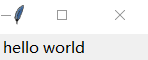

In [31]:
# 绘图
def reDraw(tolS, tolN):
    reDraw.f.clf()  # 清空原图
    reDraw.a = reDraw.f.add_subplot(111)
    if chkBtnVar.get():  # 复选框被选中
        if tolN < 2:
            tolN = 2
        myTree = createTree(reDraw.rawDat, modelLeaf, modelErr, (tolS, tolN))
        yHat = createForeCast(myTree, reDraw.testDat, modelTreeEval)
    else:
        myTree = createTree(reDraw.rawDat, ops=(tolS, tolN))
        yHat = createForeCast(myTree, reDraw.testDat)
    reDraw.a.scatter(reDraw.rawDat[:, 0].tolist(), reDraw.rawDat[:, 1].tolist(), s=5)
    reDraw.a.plot(reDraw.testDat, yHat, linewidth=2.0)
    reDraw.canvas.draw()

# 获取输入框中的值
def getInputs():
    try:
        tolN = int(tolNentry.get())
    except:
        tolN = 10
        print('enter Integer for tolN')
        tolNentry.delete(0, END)
        tolNentry.insert(0, 10)
    try:
        tolS = float(tolSentry.get())
    except:
        tolS = 1.0
        print('enter Float for tolS')
        tolSentry.delete(0, END)
        tolSentry.insert(0, '1.0')
    return tolN, tolS

def drawNewTree():
    tolN, tolS = getInputs()  # 获取输入框中的值
    reDraw(tolS, tolN)  # 绘图

root = Tk()
Label(root, text='Plot Place Holder').grid(row=0, columnspan=3)
# 第一个输入框
Label(root, text='tolN').grid(row=1, column=0)
tolNentry = Entry(root)
tolNentry.grid(row=1, column=1)
tolNentry.insert(0, '10')
# 第二个输入框
Label(root, text='tolS').grid(row=2, column=0)
tolSentry = Entry(root)
tolSentry.grid(row=2, column=1)
tolSentry.insert(0, '1.0')
# 绘制按钮
Button(root, text='ReDraw', command=drawNewTree).grid(row=1, column=2, rowspan=3)
# 复选框
chkBtnVar = IntVar()
chkBtn = Checkbutton(root, text='model tree', variable=chkBtnVar)
chkBtn.grid(row=3, column=0, columnspan=2)

# 画布
reDraw.f = Figure(figsize=(5, 4), dpi=100)
reDraw.canvas = FigureCanvasTkAgg(reDraw.f, master=root)
reDraw.canvas.draw()
reDraw.canvas.get_tk_widget().grid(row=0, columnspan=3)

reDraw.rawDat = mat(loadDataSet('sine.txt'))
reDraw.testDat = arange(min(reDraw.rawDat[:, 0]), max(reDraw.rawDat[:, 0]), 0.01)
reDraw(1.0, 10)

root.mainloop()

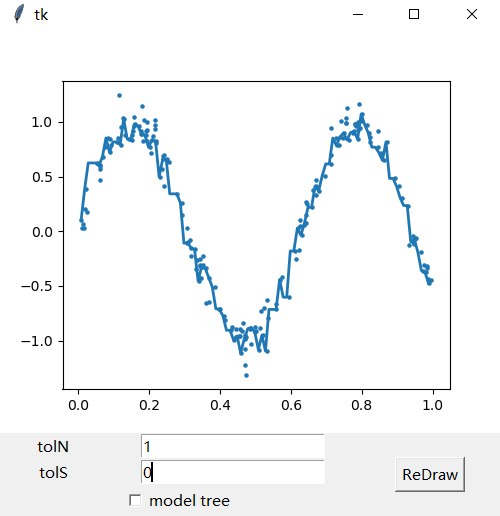

In [32]:
import sys
print(sys.version)

3.7.5 (default, Oct 31 2019, 15:18:51) [MSC v.1916 64 bit (AMD64)]
